# R2S2I Exposure time calculator

Purpose: Simulate SNR for a RS2SI on a 1-meter telescope.

How to use: You have to run this notebook *out of order*. Make sure you run the [SPECTRA] section before running THE SIMULATOR

In [71]:
import numpy as np

import astropy
import astropy.units as ur
import astropy.constants as cr

%matplotlib inline

from astropy.io import fits
from specutils import Spectrum1D
from specutils.manipulation import (box_smooth, gaussian_smooth, trapezoid_smooth)

from pylab import *

import scipy.interpolate as II

In [72]:
flu = ur.erg/ur.s/ur.cm**2/ur.Angstrom
fnu = ur.erg/ur.s/ur.cm**2/ur.Hertz
q = -22*ur.ABmag

In [73]:
Dtel = 1 * ur.meter
Atel = np.pi*(Dtel/2)**2 * 0.8 # 0.6 is for secondary + baffles


# THE SIMULATOR

In [85]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 26}

matplotlib.rc('font', **font)

In [1]:
# For convenience I simulate an A0 star with a flat (AB) spectrum
OBJMAG = 20 * ur.ABmag
lam = 500*ur.nm # Flat spectrum, so this shouldn't matter.
objfl = OBJMAG.to(flu, equivalencies=ur.spectral_density(lam))

SLITLOSS = 0.3 # 0 slitloss means all light from object enters the slit. 

# if you want to adjust the spectrum modify objfl


SKYMAGs = (21.5, 22.4, 21.8, 20.8, 19.9) * ur.ABmag
SKYLAMs = (3600, 4500, 5500, 7000, 9000) * ur.Angstrom
sky_function = np.poly1d(np.polyfit(SKYLAMs, SKYMAGs, 3))
exptime = 20 * ur.min
NPIX = 27 # 3 x 3 resolution element
R = 1000

DC = 0.0004/ur.s ; RN = 4
detnoise = np.sqrt(NPIX * DC * exptime + NPIX * RN**2)



for cqe in [blueqe, redqe]:
    lam, qe = cqe 
    
    SKYMAG = sky_function(lam) * ur.ABmag
    skyfl = SKYMAG.to(flu, equivalencies=ur.spectral_density(lam*ur.Angstrom))

    
    lmid = np.median(lam) * ur.angstrom
    BW = lmid/R
    epp = cr.c*cr.h/(lam*ur.Angstrom)
 
    obj_npp = ((objfl * exptime * Atel * qe * BW * (1-SLITLOSS))/epp).cgs
    sky_npp = ((skyfl * exptime * Atel * qe * BW * (1-SLITLOSS))/epp).cgs
    
    obj_npp_over10 = box_smooth(Spectrum1D(spectral_axis=lam*ur.Angstrom, flux=obj_npp), width=10).flux*10
    sky_npp_over10 = box_smooth(Spectrum1D(spectral_axis=lam*ur.Angstrom, flux=sky_npp), width=10).flux*10
    
    
    SNR = obj_npp/np.sqrt(obj_npp+sky_npp+detnoise**2)
    SNRover10 = obj_npp_over10/np.sqrt(obj_npp_over10+sky_npp_over10+detnoise**2)
    

    
    
    figure(1, figsize=(15,4))
    semilogy(lam, SNR, color='black')
    semilogy(lam, SNRover10, color='red')
    xlabel("Wavelength [Å]")
    legend(["R=%s" % R, "R=%s" % (R/10)])
    ylabel("SNR")
    title("For a %s A Star, in a %s exposure" % (OBJMAG, exptime))
    ylim(1,100)
    grid(True)
    
    figure(2, figsize=(15,6))
    semilogy(lam, obj_npp, color='black')
    semilogy(lam, sky_npp, color='red')
    axhline(detnoise, color='blue')
    ylim(1,500)
    
    ylabel("# Photons")
    xlabel("Wavelenght [Å]")
    grid(True)
    
figure(2)
legend(["Object # photons", "Sky # photons", "Detector noise"])

NameError: name 'ur' is not defined

In [ ]:
(objfl  * exptime * Atel * BW).to(ur.erg)

In [ ]:
(objfl*Atel).to(ur.erg/ur.s/ur.Angstrom)

In [ ]:
Atel

In [ ]:

plot(blueqe[0], blueqe[1] * spectral_density[0])

## SPECTRA

In [13]:
f = fits.open('https://dr14.sdss.org/optical/spectrum/view/data/format=fits/spec=lite?plateid=523&mjd=52026&fiberid=563')  # doctest: +IGNORE_OUTPUT +REMOTE_DATA
# The spectrum is in the second HDU of this file.
specdata = f[1].data # doctest: +REMOTE_DATA
f.close() # doctest: +REMOTE_DATA


Star is http://skyserver.sdss.org/dr15/en/tools/quicklook/summary.aspx?plate=523&mjd=52026&fiber=563



In [14]:
specdata

FITS_rec([(36.13153 , 3.5809, 0.08531194, 0, 0, 1.0583991 , 9.237367 , 34.68851 ),
          (27.535753, 3.581 , 0.09830885, 0, 0, 1.0581635 , 8.656281 , 34.37275 ),
          (35.684998, 3.5811, 0.08857997, 0, 0, 1.0579292 , 8.237594 , 35.84306 ),
          ...,
          (16.706394, 3.9639, 0.5733477 , 0, 0, 0.7020494 , 4.0404563, 15.192705),
          (16.361507, 3.964 , 0.5515458 , 0, 0, 0.702161  , 4.1537123, 15.164206),
          (17.429827, 3.9641, 0.48434803, 0, 0, 0.70227313, 4.571003 , 15.070351)],
         dtype=(numpy.record, [('flux', '>f4'), ('loglam', '>f4'), ('ivar', '>f4'), ('and_mask', '>i4'), ('or_mask', '>i4'), ('wdisp', '>f4'), ('sky', '>f4'), ('model', '>f4')]))

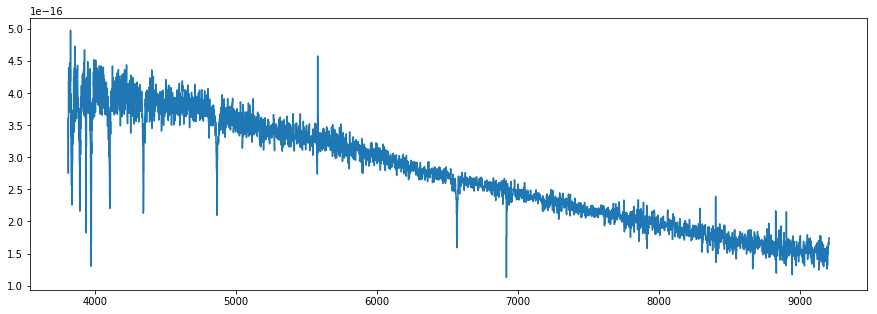

In [15]:
lamb = 10**specdata['loglam'] * ur.AA # doctest: +REMOTE_DATA
flux = specdata['flux'] * 10**-17 * ur.Unit('erg cm-2 s-1 AA-1') # doctest: +REMOTE_DATA
spec = Spectrum1D(spectral_axis=lamb, flux=flux) # doctest: +REMOTE_DATA

figure(figsize=(15,5))
step(lamb, flux)

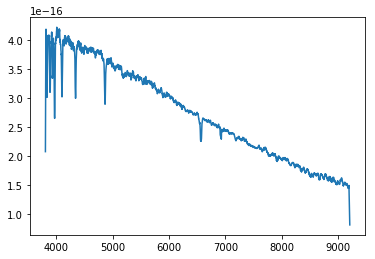

In [16]:
ss = box_smooth(spec, width=15)
plot(ss.spectral_axis, ss.flux)


# The Spectrograph throughput

Use LRIS Throughput. Ton of data so this is at the bottom

In [19]:
bluethpt = """       3101.5688     0.013179610
       3103.7723     0.012957368
       3105.9768     0.012787960
       3108.1823     0.012660165
       3110.3895     0.012574106
       3112.5967     0.012544201
       3114.8066     0.012534478
       3117.0167     0.012575891
       3119.2281     0.012649533
       3121.4404     0.012756153
       3123.6539     0.012893502
       3126.9763     0.013158775
       3129.1928     0.013355902
       3131.4102     0.013591732
       3133.6294     0.013835178
       3135.8493     0.014105082
       3138.0697     0.014409984
       3140.2920     0.014713691
       3142.5156     0.015026859
       3144.7396     0.015377681
       3146.9646     0.015732113
       3149.1916     0.016091922
       3151.4186     0.016476515
       3153.6477     0.016856764
       3155.8774     0.017260433
       3158.1080     0.017656678
       3160.3399     0.018071098
       3162.5735     0.018467307
       3164.8070     0.018908451
       3167.0425     0.019325005
       3169.2786     0.019752931
       3171.5158     0.020187267
       3173.7547     0.020605869
       3177.1140     0.021249804
       3179.3551     0.021691589
       3181.5977     0.022108947
       3183.8406     0.022538947
       3186.0849     0.022987011
       3188.3302     0.023398075
       3190.5764     0.023825980
       3192.8239     0.024240451
       3195.0724     0.024661453
       3197.3216     0.025067406
       3199.5723     0.025474346
       3201.8239     0.026027590
       3204.0765     0.026610144
       3206.3303     0.027194181
       3208.5849     0.027772796
       3210.8407     0.028351800
       3213.0977     0.028924607
       3215.3552     0.029535004
       3217.6142     0.030107084
       3219.8736     0.030684266
       3222.1343     0.031294258
       3224.3967     0.031849164
       3227.7914     0.032712054
       3230.0555     0.033310800
       3232.3213     0.033879267
       3234.5876     0.034438014
       3236.8548     0.035016336
       3239.1233     0.035584248
       3241.3923     0.036172748
       3243.6632     0.036711741
       3245.9346     0.037254782
       3248.2063     0.037850669
       3250.4802     0.038361754
       3252.7540     0.038926193
       3255.0298     0.039462330
       3257.3061     0.040011236
       3259.5832     0.040538660
       3261.8614     0.041079577
       3264.1409     0.041606923
       3266.4209     0.042112111
       3268.7021     0.042657752
       3270.9840     0.043180963
       3273.2669     0.043690516
       3275.5508     0.044194704
       3278.9786     0.044932941
       3281.2650     0.045425016
       3283.5523     0.045921351
       3285.8413     0.046373594
       3288.1300     0.046879471
       3290.4197     0.047360782
       3292.7112     0.047816576
       3295.0036     0.048267295
       3297.2960     0.048722027
       3299.5904     0.049161154
       3301.8848     0.049802389
       3304.1806     0.050459767
       3306.4774     0.051105804
       3308.7752     0.051783711
       3311.0738     0.052416905
       3313.3733     0.053059430
       3315.6735     0.053746594
       3317.9747     0.054398402
       3320.2767     0.055061456
       3322.5798     0.055699749
       3324.8842     0.056336973
       3328.3416     0.057344075
       3330.6480     0.057977848
       3332.9555     0.058597454
       3335.2636     0.059252787
       3337.5721     0.059907250
       3339.8819     0.060572877
       3342.1924     0.061199061
       3344.5046     0.061823781
       3346.8163     0.062499036
       3349.1302     0.063080655
       3351.4441     0.063767007
       3353.7595     0.064371636
       3356.0756     0.065001644
       3358.3924     0.065643535
       3360.7098     0.066270181
       3363.0283     0.066923021
       3365.3476     0.067532697
       3367.6681     0.068140076
       3369.9891     0.068803921
       3372.3118     0.069393652
       3374.6340     0.070040073
       3376.9579     0.070640299
       3380.4454     0.071560557
       3382.7706     0.072186690
       3385.0979     0.072796141
       3387.4253     0.073388463
       3389.7536     0.073978712
       3392.0826     0.074599994
       3394.4124     0.075218125
       3396.7434     0.075787021
       3399.0749     0.076417196
       3401.4079     0.076966618
       3403.7411     0.077529476
       3406.0755     0.078122097
       3408.4104     0.078697416
       3410.7458     0.079287008
       3413.0829     0.079858468
       3415.4198     0.080444269
       3417.7588     0.080978733
       3420.0977     0.081561489
       3422.4372     0.082124924
       3424.7775     0.082739044
       3427.1195     0.083264350
       3429.4615     0.083875049
       3432.9763     0.084674327
       3435.3205     0.085263719
       3437.6657     0.085798337
       3440.0116     0.086385156
       3442.3585     0.086879326
       3444.7053     0.087481098
       3447.0530     0.088062992
       3449.4025     0.088570405
       3451.7521     0.089167988
       3454.1029     0.089634384
       3456.4541     0.090191839
       3458.8052     0.090822903
       3461.1589     0.091283667
       3463.5124     0.091817276
       3465.8663     0.092445242
       3468.2218     0.092938109
       3470.5774     0.093487318
       3472.9341     0.094034721
       3475.2912     0.094561597
       3477.6493     0.095086737
       3480.0087     0.095590768
       3482.3677     0.096212292
       3485.9084     0.096993397
       3488.2705     0.097431478
       3490.6325     0.097989762
       3492.9957     0.098443867
       3495.3587     0.099060446
       3497.7232     0.099573579
       3500.0884      0.10012753
       3502.4538      0.10063721
       3504.8207      0.10114713
       3507.1884      0.10165554
       3509.5565      0.10217446
       3511.9246      0.10275259
       3514.2942      0.10335162
       3516.6643      0.10388607
       3519.0351      0.10446312
       3521.4071      0.10497459
       3523.7796      0.10555058
       3526.1524      0.10616885
       3528.5259      0.10672128
       3530.9004      0.10731797
       3533.2753      0.10784733
       3536.8397      0.10865186
       3539.2157      0.10931336
       3541.5938      0.10984168
       3543.9720      0.11041275
       3546.3508      0.11098428
       3548.7297      0.11160086
       3551.1113      0.11203408
       3553.4923      0.11260439
       3555.8734      0.11319644
       3558.2559      0.11378999
       3560.6387      0.11431177
       3563.0229      0.11481013
       3565.4067      0.11544847
       3567.7919      0.11594604
       3570.1774      0.11653727
       3572.5631      0.11715206
       3574.9510      0.11759887
       3577.3384      0.11818896
       3579.7263      0.11880387
       3582.1152      0.11939461
       3584.5051      0.11995976
       3586.8954      0.12042698
       3590.4818      0.12131104
       3592.8743      0.12182610
       3595.2669      0.12231483
       3597.6602      0.12290309
       3600.0529      0.12356785
       3602.4479      0.12410123
       3604.8434      0.12470967
       3607.2386      0.12531774
       3609.6351      0.12595303
       3612.0323      0.12651089
       3614.4297      0.12711972
       3616.8279      0.12770280
       3619.2268      0.12833865
       3621.6259      0.12894701
       3624.0260      0.12947856
       3626.4271      0.13011332
       3628.8282      0.13072243
       3631.2303      0.13135912
       3633.6328      0.13194146
       3636.0354      0.13260493
       3638.4394      0.13316107
       3640.8442      0.13366252
       3644.4518      0.13459002
       3646.8578      0.13528311
       3649.2633      0.13586450
       3651.6710      0.13644651
       3654.0786      0.13705561
       3656.4863      0.13774903
       3658.8952      0.13827512
       3661.3051      0.13882874
       3663.7153      0.13943779
       3666.1254      0.14010359
       3668.5360      0.14079846
       3670.9478      0.14132280
       3673.3607      0.14193126
       3675.7737      0.14251161
       3678.1868      0.14312004
       3680.6008      0.14372910
       3683.0153      0.14427792
       3685.4299      0.14497452
       3687.8461      0.14552411
       3690.2621      0.14619060
       3692.6788      0.14679753
       3696.3055      0.14763465
       3698.7237      0.14821027
       3701.1423      0.14883491
       3703.5615      0.14953880
       3705.9812      0.15021164
       3708.4023      0.15073245
       3710.8229      0.15137463
       3713.2443      0.15207957
       3715.6664      0.15266028
       3718.0887      0.15327143
       3720.5123      0.15388291
       3722.9358      0.15455581
       3725.3599      0.15525953
       3727.7844      0.15593216
       3730.2097      0.15657392
       3732.6359      0.15715198
       3735.0622      0.15776051
       3737.4887      0.15840055
       3739.9156      0.15913603
       3742.3441      0.15971205
       3744.7723      0.16031823
       3747.2012      0.16092383
       3750.8450      0.16199460
       3753.2749      0.16259921
       3755.7063      0.16320313
       3758.1364      0.16400359
       3760.5690      0.16450778
       3763.0011      0.16510915
       3765.4335      0.16584224
       3767.8671      0.16637671
       3770.3009      0.16700962
       3772.7349      0.16760807
       3775.1692      0.16830612
       3777.6048      0.16886900
       3780.0401      0.16956546
       3782.4761      0.17022957
       3784.9133      0.17072067
       3787.3498      0.17141551
       3789.7870      0.17204130
       3792.2250      0.17269965
       3794.6637      0.17325539
       3797.1036      0.17384337
       3799.5426      0.17456894
       3801.9830      0.17508586
       3805.6434      0.17613530
       3808.0840      0.17678940
       3810.5254      0.17737105
       3812.9678      0.17802019
       3815.4106      0.17852810
       3817.8530      0.17928365
       3820.2966      0.17982265
       3822.7409      0.18036079
       3825.1850      0.18104117
       3827.6300      0.18161153
       3830.0748      0.18228926
       3832.5206      0.18293007
       3834.9664      0.18356902
       3837.4134      0.18409688
       3839.8602      0.18465865
       3842.3081      0.18525701
       3844.7556      0.18588826
       3847.2039      0.18648145
       3849.6531      0.18703701
       3852.1020      0.18770294
       3854.5515      0.18829093
       3857.0017      0.18891550
       3860.6774      0.18980986
       3863.1281      0.19043176
       3865.5805      0.19089793
       3868.0323      0.19147362
       3870.4850      0.19201215
       3872.9373      0.19262402
       3875.3909      0.19311897
       3877.8445      0.19380314
       3880.2981      0.19440938
       3882.7530      0.19485733
       3885.2078      0.19549844
       3887.6628      0.19613643
       3890.1184      0.19665548
       3892.5744      0.19732914
       3895.0312      0.19784420
       3897.4882      0.19827779
       3899.9460      0.19882573
       3902.4030      0.19953815
       3904.8610      0.20009415
       3907.3195      0.20068513
       3909.7784      0.20123622
       3913.4669      0.20221646
       3915.9278      0.20263982
       3918.3875      0.20330046
       3920.8480      0.20404111
       3923.3094      0.20449589
       3925.7703      0.20511100
       3928.2327      0.20555989
       3930.6941      0.20629126
       3933.1570      0.20669353
       3935.6199      0.20738050
       3938.0820      0.20810622
       3940.5466      0.20854115
       3943.0105      0.20917981
       3945.4743      0.20973096
       3947.9396      0.21024198
       3950.4045      0.21083004
       3952.8698      0.21133335
       3955.3356      0.21191593
       3957.8021      0.21241143
       3960.2684      0.21298933
       3962.7352      0.21352280
       3965.2023      0.21413744
       3968.9034      0.21498890
       3971.3719      0.21538423
       3973.8399      0.21594607
       3976.3091      0.21646178
       3978.7781      0.21706061
       3981.2476      0.21757116
       3983.7171      0.21811924
       3986.1873      0.21866575
       3988.6575      0.21916539
       3991.1282      0.21966323
       3993.5996      0.22011279
       3996.0713      0.22069111
       3998.5432      0.22100280
       4001.0153      0.22162560
       4003.4873      0.22230241
       4005.9602      0.22262699
       4008.4335      0.22312340
       4010.9072      0.22365813
       4013.3803      0.22427974
       4015.8542      0.22467792
       4018.3288      0.22520329
       4020.8036      0.22568324
       4024.5160      0.22641633
       4026.9913      0.22697738
       4029.4672      0.22730801
       4031.9437      0.22785912
       4034.4195      0.22840845
       4036.8966      0.22877609
       4039.3731      0.22936273
       4041.8509      0.22972066
       4044.3280      0.23020943
       4046.8065      0.23051487
       4049.2842      0.23108940
       4051.7627      0.23151985
       4054.2410      0.23199785
       4056.7200      0.23255952
       4059.2000      0.23284414
       4061.6792      0.23335434
       4064.1592      0.23381634
       4066.6397      0.23413515
       4069.1199      0.23458613
       4071.6008      0.23498940
       4074.0815      0.23552773
       4076.5632      0.23578226
       4080.2851      0.23653080
       4082.7676      0.23682261
       4085.2497      0.23715844
       4087.7317      0.23781507
       4090.2150      0.23809567
       4092.6977      0.23860694
       4095.1816      0.23883167
       4097.6650      0.23923926
       4100.1489      0.23954855
       4102.6332      0.23994983
       4105.1171      0.24025247
       4107.6025      0.24064420
       4110.0868      0.24103435
       4112.5722      0.24132330
       4115.0575      0.24170590
       4117.5429      0.24227196
       4120.0292      0.24235768
       4122.5145      0.24301472
       4125.0014      0.24318810
       4127.4877      0.24364384
       4129.9750      0.24390534
       4133.7062      0.24424108
       4136.1925      0.24477910
       4138.6808      0.24512332
       4141.1686      0.24536446
       4143.6573      0.24550655
       4146.1451      0.24603082
       4148.6339      0.24635698
       4151.1231      0.24648639
       4153.6129      0.24670679
       4156.1012      0.24721590
       4158.5909      0.24752589
       4161.0811      0.24773391
       4163.5714      0.24784185
       4166.0606      0.24843369
       4168.5518      0.24853304
       4171.0426      0.24882241
       4173.5333      0.24910765
       4176.0240      0.24929237
       4178.5157      0.24957032
       4181.0074      0.24994178
       4183.4986      0.25021146
       4185.9903      0.25047806
       4189.7298      0.25057446
       4192.2220      0.25092828
       4194.7151      0.25108175
       4197.2078      0.25123081
       4199.7005      0.25157204
       4202.1937      0.25181301
       4204.6878      0.25195009
       4207.1805      0.25247825
       4209.6746      0.25250903
       4212.1692      0.25263292
       4214.6629      0.25295332
       4217.1580      0.25296836
       4219.6521      0.25337914
       4222.1473      0.25348976
       4224.6429      0.25349677
       4227.1375      0.25379332
       4229.6331      0.25389159
       4232.1292      0.25408577
       4234.6243      0.25437269
       4237.1199      0.25465763
       4239.6165      0.25463844
       4242.1126      0.25491679
       4245.8579      0.25507470
       4248.3540      0.25524456
       4250.8516      0.25530902
       4253.3482      0.25556864
       4255.8452      0.25572734
       4258.3433      0.25577931
       4260.8409      0.25582785
       4263.3389      0.25597409
       4265.8360      0.25621707
       4268.3345      0.25625417
       4270.8326      0.25648824
       4273.3311      0.25652070
       4275.8296      0.25664887
       4278.3286      0.25677252
       4280.8277      0.25689276
       4283.3267      0.25700957
       4285.8257      0.25702249
       4288.3247      0.25723294
       4290.8247      0.25724118
       4293.3243      0.25734312
       4295.8243      0.25734215
       4298.3238      0.25763963
       4302.0745      0.25757681
       4304.5745      0.25766492
       4307.0755      0.25764886
       4309.5755      0.25783080
       4312.0765      0.25790855
       4314.5774      0.25798512
       4317.0784      0.25795397
       4319.5799      0.25802358
       4322.0804      0.25818835
       4324.5823      0.25815011
       4327.0838      0.25820931
       4329.5853      0.25826505
       4332.0872      0.25831730
       4334.5892      0.25826625
       4337.0911      0.25831264
       4339.5936      0.25835785
       4342.0955      0.25829745
       4344.5980      0.25843667
       4347.0999      0.25857133
       4349.6033      0.25840168
       4352.1063      0.25853163
       4355.8604      0.25856917
       4358.3634      0.25869331
       4360.8668      0.25851070
       4363.3702      0.25852789
       4365.8731      0.25864267
       4368.3770      0.25845190
       4370.8809      0.25846090
       4373.3839      0.25866852
       4375.8883      0.25846954
       4378.3922      0.25857140
       4380.8966      0.25856984
       4383.4005      0.25856366
       4385.9049      0.25845862
       4388.4093      0.25844659
       4390.9132      0.25853667
       4393.4176      0.25852334
       4395.9230      0.25830566
       4398.4274      0.25838636
       4400.9327      0.25826502
       4403.4371      0.25824117
       4405.9425      0.25821497
       4408.4479      0.25808668
       4412.2055      0.25803976
       4414.7108      0.25810738
       4417.2162      0.25807175
       4419.7211      0.25813353
       4422.2274      0.25789266
       4424.7333      0.25795084
       4427.2382      0.25800896
       4429.7445      0.25776343
       4432.2509      0.25771380
       4434.7563      0.25766520
       4437.2626      0.25761431
       4439.7685      0.25765949
       4442.2744      0.25750433
       4444.7817      0.25744644
       4447.2871      0.25768818
       4449.7944      0.25722647
       4452.3012      0.25716386
       4454.8071      0.25719944
       4457.3134      0.25713329
       4459.8203      0.25706595
       4462.3271      0.25689698
       4464.8340      0.25682502
       4468.5945      0.25671700
       4471.1018      0.25654236
       4473.6081      0.25656710
       4476.1155      0.25648812
       4478.6223      0.25661074
       4481.1296      0.25633000
       4483.6375      0.25624636
       4486.1448      0.25596474
       4488.6521      0.25607893
       4491.1590      0.25609407
       4493.6673      0.25580565
       4496.1736      0.25591727
       4498.6814      0.25572768
       4501.1893      0.25573890
       4503.6966      0.25565351
       4506.2049      0.25556587
       4508.7122      0.25527962
       4511.2210      0.25509222
       4513.7279      0.25510085
       4516.2357      0.25500970
       4518.7430      0.25521424
       4521.2528      0.25462481
       4525.0133      0.25478320
       4527.5216      0.25468623
       4530.0294      0.25458920
       4532.5382      0.25449216
       4535.0460      0.25429342
       4537.5548      0.25419520
       4540.0621      0.25419404
       4542.5709      0.25409238
       4545.0787      0.25389141
       4547.5875      0.25378970
       4550.0949      0.25388523
       4552.6046      0.25358285
       4555.1115      0.25367479
       4557.6208      0.25327459
       4560.1281      0.25346421
       4562.6379      0.25306086
       4565.1457      0.25305006
       4567.6545      0.25284478
       4570.1623      0.25293157
       4572.6716      0.25262638
       4575.1789      0.25271183
       4578.9423      0.25244936
       4581.4511      0.25214005
       4583.9590      0.25232257
       4586.4682      0.25201437
       4588.9766      0.25209811
       4591.4858      0.25178892
       4593.9932      0.25196977
       4596.5024      0.25156004
       4599.0103      0.25164331
       4601.5195      0.25133108
       4604.0274      0.25131366
       4606.5367      0.25110092
       4609.0450      0.25118155
       4611.5542      0.25086850
       4614.0621      0.25084751
       4616.5718      0.25044012
       4619.0797      0.25051581
       4621.5889      0.25030001
       4624.0963      0.25037881
       4626.6060      0.24996750
       4629.1139      0.24994724
       4631.6222      0.24992473
       4635.3846      0.24984253
       4637.8924      0.25001631
       4640.4022      0.24950765
       4642.9105      0.24958128
       4645.4198      0.24907224
       4647.9276      0.24924191
       4650.4359      0.24902307
       4652.9447      0.24890380
       4655.4530      0.24868511
       4657.9613      0.24865977
       4660.4706      0.24824921
       4662.9780      0.24832079
       4665.4872      0.24800537
       4667.9946      0.24826966
       4670.5039      0.24776258
       4673.0112      0.24793062
       4675.5205      0.24761434
       4678.0278      0.24768422
       4680.5361      0.24746372
       4683.0444      0.24734325
       4685.5522      0.24731616
       4688.0605      0.24709361
       4691.8225      0.24700449
       4694.3298      0.24697718
       4696.8382      0.24675686
       4699.3460      0.24673161
       4701.8548      0.24637230
       4704.3621      0.24641871
       4706.8704      0.24627032
       4709.3777      0.24631656
       4711.8861      0.24616916
       4714.3934      0.24640455
       4716.8997      0.24654582
       4719.4076      0.24658969
       4721.9154      0.24644185
       4724.4227      0.24658296
       4726.9300      0.24643280
       4729.4383      0.24618862
       4731.9452      0.24623094
       4734.4535      0.24579352
       4736.9603      0.24593284
       4739.4672      0.24597384
       4741.9740      0.24620718
       4744.4814      0.24596060
       4748.2433      0.24568657
       4750.7487      0.24591931
       4753.2565      0.24595890
       4755.7629      0.24580721
       4758.2712      0.24527291
       4760.7775      0.24540695
       4763.2829      0.24554095
       4765.7903      0.24567504
       4768.2966      0.24552103
       4770.8044      0.24498484
       4773.3108      0.24521311
       4775.8157      0.24534450
       4778.3240      0.24518835
       4780.8294      0.24532068
       4783.3362      0.24478348
       4785.8421      0.24529547
       4788.3475      0.24504100
       4790.8548      0.24459767
       4793.3616      0.24472724
       4795.8646      0.24504601
       4798.3729      0.24460037
       4802.1300      0.24498092
       4804.6373      0.24415422
       4807.1432      0.24456550
       4809.6471      0.24478371
       4812.1529      0.24414391
       4814.6598      0.24417295
       4817.1637      0.24448723
       4819.6676      0.24422521
       4822.1764      0.24387253
       4824.6803      0.24418195
       4827.1823      0.24439714
       4829.6891      0.24394430
       4832.1955      0.24396533
       4834.6989      0.24408369
       4837.2018      0.24382053
       4839.7087      0.24364760
       4842.2146      0.24366724
       4844.7170      0.24387725
       4847.2204      0.24341941
       4849.7258      0.24334050
       4852.2317      0.24345072
       4854.7341      0.24356078
       4858.4893      0.24305943
       4860.9946      0.24297605
       4863.4995      0.24327162
       4866.0020      0.24328194
       4868.5044      0.24291101
       4871.0079      0.24273034
       4873.5123      0.24264139
       4876.0181      0.24264837
       4878.5201      0.24284061
       4881.0220      0.24256056
       4883.5240      0.24256184
       4886.0269      0.24237464
       4888.5313      0.24199829
       4891.0362      0.24218453
       4893.5387      0.24218025
       4896.0397      0.24217586
       4898.5416      0.24198326
       4901.0431      0.24188209
       4903.5456      0.24168539
       4906.0470      0.24158103
       4908.5495      0.24138126
       4911.0558      0.24071191
       4914.8085      0.24130222
       4917.3095      0.24128564
       4919.8100      0.24117368
       4922.3115      0.24106066
       4924.8130      0.24085240
       4927.3134      0.24083031
       4929.8144      0.24071196
       4932.3154      0.24059360
       4934.8164      0.24047419
       4937.3169      0.24035054
       4939.8179      0.24022690
       4942.3184      0.24010219
       4944.8189      0.24006814
       4947.3194      0.23984434
       4949.8199      0.23971439
       4952.3204      0.23958234
       4954.8209      0.23944924
       4957.3209      0.23931403
       4959.8209      0.23926921
       4962.3209      0.23913083
       4964.8209      0.23899038
       4968.5711      0.23877607
       4971.0711      0.23853720
       4973.5712      0.23839058
       4976.0653      0.23861343
       4978.5638      0.23827608
       4981.0629      0.23793811
       4983.5624      0.23787623
       4986.0619      0.23781220
       4988.5614      0.23756134
       4991.0610      0.23740030
       4993.5600      0.23733204
       4996.0546      0.23725942
       4998.5517      0.23709309
       5001.0507      0.23673799
       5003.5498      0.23665630
       5006.0488      0.23638762
       5008.5439      0.23695012
       5011.0400      0.23630592
       5013.5381      0.23594001
       5016.0366      0.23575471
       5018.5356      0.23556746
       5021.0293      0.23565627
       5024.7747      0.23509267
       5027.2727      0.23499135
       5029.7669      0.23553239
       5032.2625      0.23478016
       5034.7610      0.23430599
       5037.2586      0.23410397
       5039.7508      0.23435637
       5042.2479      0.23369186
       5044.7454      0.23348509
       5047.2381      0.23364121
       5049.7337      0.23315352
       5052.2313      0.23302890
       5054.7240      0.23299311
       5057.2196      0.23250256
       5059.7147      0.23264352
       5062.2084      0.23224018
       5064.7045      0.23173984
       5067.1972      0.23214807
       5069.6913      0.23164572
       5072.1859      0.23168511
       5074.6791      0.23136034
       5077.1752      0.23076230
       5080.9133      0.23076499
       5083.4079      0.23061350
       5085.9006      0.23009889
       5088.3952      0.22985179
       5090.8864      0.22978436
       5093.3806      0.22944475
       5095.8718      0.22927962
       5098.3655      0.22893760
       5100.8572      0.22876874
       5103.3499      0.22859998
       5105.8416      0.22833895
       5108.3338      0.22825457
       5110.8260      0.22772067
       5113.3172      0.22763037
       5115.8099      0.22709484
       5118.3001      0.22708941
       5120.7918      0.22672721
       5123.2830      0.22636352
       5125.7728      0.22644147
       5128.2650      0.22589554
       5130.7547      0.22570243
       5133.2450      0.22577305
       5136.9811      0.22516579
       5139.4718      0.22461184
       5141.9610      0.22449744
       5144.4503      0.22429339
       5146.9406      0.22391143
       5149.4303      0.22343979
       5151.9191      0.22331596
       5154.4079      0.22327939
       5156.8976      0.22280302
       5159.3864      0.22241062
       5161.8747      0.22219148
       5164.3635      0.22205931
       5166.8513      0.22175078
       5169.3405      0.22117831
       5171.8283      0.22086606
       5174.3156      0.22072473
       5176.8029      0.22066870
       5179.2907      0.22026411
       5181.7790      0.21968361
       5184.2663      0.21936260
       5186.7532      0.21904008
       5190.4829      0.21872461
       5192.9702      0.21831181
       5195.4570      0.21798395
       5197.9434      0.21756857
       5200.4292      0.21732185
       5202.9151      0.21707345
       5205.4009      0.21673866
       5207.8868      0.21640337
       5210.3721      0.21615014
       5212.8570      0.21598064
       5215.3423      0.21563973
       5217.8272      0.21529836
       5220.3121      0.21495368
       5222.7970      0.21460858
       5225.2813      0.21417741
       5227.7662      0.21383065
       5230.2506      0.21348062
       5232.7345      0.21313204
       5235.2184      0.21278026
       5237.7023      0.21234597
       5240.1857      0.21207451
       5242.6686      0.21180336
       5246.3935      0.21134982
       5248.8764      0.21090896
       5251.3588      0.21064530
       5253.8412      0.21038790
       5256.3237      0.21004683
       5258.8061      0.20970718
       5261.2885      0.20928160
       5263.7709      0.20893760
       5266.2519      0.20859220
       5268.7329      0.20849259
       5271.2148      0.20797976
       5273.6967      0.20746904
       5276.1762      0.20744537
       5278.6577      0.20701314
       5281.1387      0.20666157
       5283.6191      0.20622539
       5286.0991      0.20595282
       5288.5796      0.20576008
       5291.0601      0.20516071
       5293.5391      0.20504511
       5296.0191      0.20468580
       5298.4986      0.20424631
       5302.2181      0.20354407
       5304.6956      0.20349970
       5307.1751      0.20313486
       5309.6536      0.20269045
       5312.1317      0.20240422
       5314.6102      0.20195511
       5317.0887      0.20166631
       5319.5662      0.20129651
       5322.0443      0.20084617
       5324.5208      0.20071033
       5326.9984      0.20041341
       5329.4764      0.19988064
       5331.9530      0.19958221
       5334.4300      0.19920282
       5336.9066      0.19890007
       5339.3827      0.19851924
       5341.8602      0.19797997
       5344.3363      0.19759473
       5346.8124      0.19713054
       5349.2870      0.19697680
       5351.7626      0.19658648
       5354.2382      0.19619429
       5357.9508      0.19575691
       5360.4264      0.19528307
       5362.9006      0.19488302
       5365.3752      0.19448377
       5367.8503      0.19407849
       5370.3244      0.19359744
       5372.7980      0.19326684
       5375.2717      0.19308428
       5377.7453      0.19251844
       5380.2190      0.19210265
       5382.6926      0.19160862
       5385.1657      0.19126356
       5387.6384      0.19076317
       5390.1111      0.19041118
       5392.5832      0.19013243
       5395.0559      0.18984820
       5397.5281      0.18918345
       5399.9998      0.18889142
       5402.4714      0.18844744
       5404.9431      0.18792441
       5407.4148      0.18754604
       5411.1221      0.18685711
       5413.5933      0.18631952
       5416.0635      0.18592460
       5418.5347      0.18545068
       5421.0044      0.18504533
       5423.4747      0.18456138
       5425.9449      0.18407219
       5428.4141      0.18372215
       5430.8843      0.18307746
       5433.3536      0.18264098
       5435.8228      0.18212791
       5438.2926      0.18153650
       5440.7613      0.18101054
       5443.2306      0.18047656
       5445.6988      0.17993698
       5448.1671      0.17952981
       5450.6354      0.17897334
       5453.1036      0.17840915
       5455.5709      0.17790604
       5458.0382      0.17739496
       5460.5065      0.17659272
       5462.9728      0.17592453
       5466.6737      0.17521454
       5469.1410      0.17452008
       5471.6073      0.17402309
       5474.0741      0.17337515
       5476.5395      0.17264990
       5479.0058      0.17191256
       5481.4716      0.17129867
       5483.9379      0.17053709
       5486.4028      0.16996533
       5488.8676      0.16931215
       5491.3329      0.16851041
       5493.7973      0.16789444
       5496.2626      0.16693358
       5498.7275      0.16615467
       5501.1918      0.16536119
       5503.6547      0.16481373
       5506.1186      0.16392143
       5508.5830      0.16314067
       5511.0463      0.16208569
       5513.5107      0.16120596
       5515.9731      0.16043516
       5518.4355      0.15957968
       5522.1291      0.15828930
       5524.5920      0.15725654
       5527.0544      0.15632588
       5529.5168      0.15506458
       5531.9792      0.15402840
       5534.4402      0.15315101
       5536.9026      0.15206610
       5539.3645      0.15077546
       5541.8250      0.14982040
       5544.2854      0.14865836
       5546.7473      0.14752608
       5549.2078      0.14613577
       5551.6668      0.14523610
       5554.1282      0.14378711
       5556.5872      0.14248008
       5559.0471      0.14119734
       5561.5071      0.13982722
       5563.9671      0.13842294
       5566.4261      0.13698636
       5568.8855      0.13551231
       5571.3440      0.13400461
       5573.8025      0.13256490
       5577.4908      0.13017443
       5579.9483      0.12858306
       5582.4068      0.12669749
       5584.8643      0.12507386
       5587.3223      0.12330736
       5589.7803      0.12144893
       5592.2364      0.11983455
       5594.6944      0.11774210
       5597.1500      0.11593330"""
redthpt = """       5526.4196    0.0026145745
       5530.9667    0.0081130955
       5535.5157     0.013495044
       5540.0653     0.018788132
       5544.6163     0.023871400
       5549.1648     0.029005967
       5554.8548     0.035177925
       5559.4077     0.039994491
       5563.9612     0.044764330
       5568.5156     0.049339174
       5573.0715     0.053806386
       5577.6264     0.058215973
       5582.1813     0.062580739
       5586.7381     0.066888568
       5591.2959     0.071052168
       5595.8543     0.075062680
       5600.4136     0.079047430
       5606.1128     0.083943143
       5610.6731     0.087775963
       5615.2348     0.091451399
       5619.7966     0.095083778
       5624.3598     0.098678208
       5628.9235      0.10202239
       5633.4872      0.10546271
       5638.0533      0.10869057
       5642.6175      0.11193303
       5647.1836      0.11520233
       5652.8951      0.11871509
       5657.4641      0.12151399
       5662.0327      0.12449900
       5666.6013      0.12758304
       5671.1709      0.13061257
       5675.7424      0.13324500
       5680.3129      0.13592441
       5684.8844      0.13854199
       5689.4579      0.14091875
       5694.0338      0.14304823
       5698.6077      0.14578741
       5704.3250      0.14887591
       5708.9019      0.15099265
       5713.4798      0.15298347
       5718.0567      0.15537595
       5722.6350      0.15758762
       5727.2124      0.15981661
       5731.7942      0.16131303
       5736.3740      0.16357948
       5740.9538      0.16566436
       5745.5351      0.16756293
       5750.1193      0.16905408
       5755.8459      0.17162014
       5760.4320      0.17281831
       5765.0167      0.17485593
       5769.5995      0.17663250
       5774.1890      0.17738641
       5778.7737      0.17961081
       5783.3614      0.18080625
       5787.9505      0.18234801
       5792.5376      0.18400779
       5797.1301      0.18445616
       5801.7182      0.18659408
       5807.4575      0.18799535
       5812.0476      0.18959115
       5816.6421      0.19026732
       5821.2326      0.19204403
       5825.8286      0.19256715
       5830.4206      0.19445394
       5835.0180      0.19474292
       5839.6124      0.19641176
       5844.2108      0.19671726
       5848.8058      0.19850301
       5854.5529      0.19992557
       5859.1552      0.19987776
       5863.7526      0.20133343
       5868.3534      0.20217094
       5872.9547      0.20255139
       5877.5540      0.20411494
       5882.1592      0.20410141
       5886.7591      0.20562700
       5891.3638      0.20626160
       5895.9690      0.20643877
       5900.5713      0.20817342
       5906.3292      0.20866889
       5910.9358      0.20948435
       5915.5440      0.20975133
       5920.1502      0.21070952
       5924.7573      0.21174728
       5929.3689      0.21168840
       5933.9775      0.21215418
       5938.5876      0.21323435
       5943.1982      0.21384979
       5947.8117      0.21409146
       5952.4238      0.21449897
       5958.1904      0.21530839
       5962.8039      0.21568671
       5967.4179      0.21641885
       5972.0314      0.21750938
       5976.6469      0.21794672
       5981.2653      0.21781976
       5985.8832      0.21823645
       5990.5002      0.21873447
       5995.1181      0.21913243
       5999.7374      0.21980117
       6004.3563      0.22069436
       6010.1332      0.22058968
       6014.7541      0.22100277
       6019.3759      0.22150309
       6023.9977      0.22227759
       6028.6205      0.22295578
       6033.2448      0.22334445
       6037.8695      0.22372977
       6042.4938      0.22448892
       6047.1200      0.22476739
       6051.7462      0.22523393
       6057.5314      0.22524042
       6062.1586      0.22579294
       6066.7863      0.22624832
       6071.4145      0.22698743
       6076.0431      0.22753492
       6080.6737      0.22788541
       6085.3048      0.22842986
       6089.9374      0.22868207
       6094.5704      0.22912458
       6099.2025      0.22927857
       6103.8361      0.22962311
       6109.6281      0.23066011
       6114.2636      0.23100347
       6118.8986      0.23115319
       6123.5370      0.23110705
       6128.1735      0.23154730
       6132.8095      0.23228184
       6137.4474      0.23291942
       6142.0858      0.23355965
       6146.7267      0.23321932
       6151.3666      0.23366511
       6156.0060      0.23450572
       6161.8088      0.23467214
       6166.4492      0.23552025
       6171.0920      0.23597206
       6175.7353      0.23593295
       6180.3791      0.23658887
       6185.0229      0.23734967
       6189.6687      0.23741219
       6194.3149      0.23787751
       6198.9602      0.23824522
       6203.6064      0.23911904
       6208.2561      0.23888978
       6214.0662      0.23918374
       6218.7124      0.24046997
       6223.3626      0.24075340
       6228.0142      0.24083494
       6232.6638      0.24162839
       6237.3155      0.24161659
       6241.9661      0.24241772
       6246.6197      0.24292149
       6251.2727      0.24342509
       6255.9258      0.24414072
       6261.7437      0.24468137
       6266.3993      0.24509676
       6271.0543      0.24561838
       6275.7113      0.24593792
       6280.3673      0.24667553
       6285.0262      0.24679456
       6289.6827      0.24774764
       6294.3417      0.24787345
       6298.9996      0.24904587
       6303.6605      0.24897087
       6308.3204      0.24963026
       6314.1477      0.24990916
       6318.8095      0.25057741
       6323.4719      0.25103999
       6328.1333      0.25203289
       6332.7976      0.25218652
       6337.4619      0.25297816
       6342.1267      0.25345586
       6346.7915      0.25404584
       6351.4563      0.25484964
       6356.1235      0.25502011
       6360.7913      0.25572687
       6366.6248      0.25626846
       6371.2940      0.25666262
       6375.9613      0.25781352
       6380.6314      0.25810664
       6385.3011      0.25883607
       6389.9718      0.25924389
       6394.6429      0.25997975
       6399.3151      0.26039490
       6403.9867      0.26124848
       6408.6593      0.26188728
       6413.3329      0.26241917
       6419.1758      0.26322989
       6423.8503      0.26376887
       6428.5259      0.26431349
       6433.2014      0.26496965
       6437.8775      0.26585255
       6442.5550      0.26618244
       6447.2320      0.26696010
       6451.9100      0.26762941
       6456.5889      0.26819074
       6461.2674      0.26909086
       6467.1176      0.26948951
       6471.7985      0.27028217
       6476.4794      0.27085210
       6481.1613      0.27142790
       6485.8427      0.27234185
       6490.5251      0.27303326
       6495.2075      0.27407030
       6499.8913      0.27442456
       6504.5771      0.27440592
       6509.2620      0.27518892
       6513.9463      0.27608918
       6519.8043      0.27692860
       6524.4911      0.27737469
       6529.1783      0.27816564
       6533.8661      0.27884360
       6538.5538      0.27940521
       6543.2426      0.28008593
       6547.9328      0.28053402
       6552.6220      0.28156449
       6557.3122      0.28213110
       6562.0039      0.28269878
       6566.6946      0.28350014
       6572.5604      0.28423923
       6577.2530      0.28480693
       6581.9456      0.28549348
       6586.6397      0.28606095
       6591.3334      0.28686743
       6596.0280      0.28731493
       6600.7235      0.28788185
       6605.4186      0.28892899
       6610.1147      0.28985630
       6614.8122      0.29054397
       6619.5102      0.29087010
       6625.3824      0.29196872
       6630.0823      0.29216788
       6634.7808      0.29273056
       6639.4798      0.29353386
       6644.1788      0.29409633
       6648.8798      0.29526732
       6653.5817      0.29570301
       6658.2841      0.29613791
       6662.9855      0.29656805
       6667.6879      0.29761242
       6673.5660      0.29858265
       6678.2723      0.29888344
       6682.9766      0.29955508
       6687.6810      0.29972614
       6692.3854      0.30101612
       6697.0922      0.30168423
       6701.7995      0.30197153
       6706.5043      0.30275706
       6711.2131      0.30329145
       6715.9218      0.30407495
       6720.6296      0.30422493
       6726.5150      0.30529132
       6731.2252      0.30606743
       6735.9359      0.30658674
       6740.6447      0.30773993
       6745.3568      0.30812515
       6750.0690      0.30812342
       6754.7802      0.30913945
       6759.4934      0.30990143
       6764.2055      0.31014293
       6768.9197      0.31076650
       6773.6343      0.31113008
       6779.5265      0.31177210
       6784.2421      0.31290242
       6788.9582      0.31312503
       6793.6738      0.31399095
       6798.3913      0.31420027
       6803.1074      0.31492916
       6807.8264      0.31526343
       6812.5420      0.31624295
       6817.2620      0.31696095
       6821.9791      0.31741256
       6826.7005      0.31785786
       6832.5995      0.31831187
       6837.3210      0.31901155
       6842.0410      0.31930844
       6846.7629      0.32013376
       6851.4839      0.32055529
       6856.2083      0.32137087
       6860.9298      0.32164822
       6865.6546      0.32192435
       6870.3771      0.32259270
       6875.1020      0.32285659
       6881.0073      0.32378213
       6885.7337      0.32376362
       6890.4585      0.32494714
       6895.1849      0.32518950
       6899.9122      0.32582952
       6904.6390      0.32605651
       6909.3668      0.32668934
       6914.0942      0.32744687
       6918.8230      0.32752495
       6923.5537      0.32732685
       6928.2815      0.32861035
       6934.1937      0.32905731
       6938.9264      0.32924517
       6943.6557      0.32970207
       6948.3864      0.33028713
       6953.1206      0.33032147
       6957.8513      0.33130432
       6962.5845      0.33132826
       6967.3177      0.33175538
       6972.0518      0.33258874
       6976.7850      0.33259332
       6981.5197      0.33300118
       6987.4392      0.33336879
       6992.1748      0.33390341
       6996.9099      0.33401741
       7001.6461      0.33453309
       7006.3846      0.33448003
       7011.1217      0.33497366
       7015.8578      0.33546189
       7020.5969      0.33552616
       7025.3359      0.33572440
       7030.0754      0.33619420
       7034.8140      0.33679463
       7040.7384      0.33719572
       7045.4789      0.33736621
       7050.2189      0.33767303
       7054.9609      0.33797259
       7059.7034      0.33798870
       7064.4453      0.33841608
       7069.1863      0.33883635
       7073.9293      0.33911404
       7078.6732      0.33910282
       7083.4162      0.33964584
       7089.3479      0.33968891
       7094.0928      0.33993983
       7098.8377      0.34004443
       7103.5841      0.34000112
       7108.3285      0.34065406
       7113.0749      0.34060284
       7117.8217      0.34082236
       7122.5700      0.34075745
       7127.3169      0.34110706
       7132.0642      0.34145238
       7136.8135      0.34151291
       7142.7497      0.34175076
       7147.4990      0.34193561
       7152.2483      0.34211741
       7156.9995      0.34215040
       7161.7488      0.34245833
       7166.5001      0.34247901
       7171.2518      0.34249658
       7176.0031      0.34278635
       7180.7558      0.34279314
       7185.5085      0.34279374
       7190.2612      0.34307131
       7196.2037      0.34308980
       7200.9560      0.34349399
       7205.7106      0.34333113
       7210.4653      0.34344412
       7215.2200      0.34369282
       7219.9746      0.34379506
       7224.7313      0.34346861
       7229.4879      0.34384224
       7234.2435      0.34407104
       7239.0012      0.34387071
       7243.7573      0.34437137
       7249.7051      0.34417784
       7254.4642      0.34410246
       7259.2223      0.34373995
       7263.9804      0.34422018
       7268.7404      0.34370786
       7273.5005      0.34389472
       7278.2596      0.34407847
       7283.0191      0.34439980
       7287.7801      0.34429162
       7292.5416      0.34432094
       7298.4944      0.34378737
       7303.2554      0.34408821
       7308.0174      0.34438616
       7312.7804      0.34397355
       7317.5439      0.34383751
       7322.3073      0.34412428
       7327.0693      0.34440352
       7331.8352      0.34383784
       7336.5987      0.34396855
       7341.3636      0.34409621
       7346.1281      0.34421922
       7352.0862      0.34377148
       7356.8516      0.34374760
       7361.6185      0.34357875
       7366.3844      0.34383083
       7371.1518      0.34379147
       7375.9191      0.34347282
       7380.6865      0.34343170
       7385.4553      0.34338600
       7390.2227      0.34362065
       7394.9925      0.34300628
       7399.7628      0.34323601
       7405.7229      0.34330135
       7410.4927      0.34296411
       7415.2635      0.34303962
       7420.0348      0.34269188
       7424.8041      0.34290404
       7429.5759      0.34241177
       7434.3472      0.34262053
       7439.1189      0.34240344
       7443.8907      0.34246449
       7448.6654      0.34196488
       7453.4367      0.34202254
       7459.4036      0.34219563
       7464.1768      0.34210881
       7468.9500      0.34173962
       7473.7252      0.34178928
       7478.4999      0.34127628
       7483.2746      0.34132110
       7488.0493      0.34150523
       7492.8250      0.34098928
       7497.6021      0.34074776
       7502.3768      0.34120679
       7508.3486      0.34066194
       7513.1263      0.34027820
       7517.9014      0.34045348
       7522.6805      0.34034466
       7527.4562      0.34051670
       7532.2353      0.34012969
       7537.0134      0.34029990
       7541.7925      0.33963381
       7546.5716      0.33980204
       7551.3497      0.33982841
       7556.1313      0.33957723
       7562.1050      0.33929679
       7566.8861      0.33946435
       7571.6656      0.33893447
       7576.4477      0.33895719
       7581.2273      0.33898122
       7586.0103      0.33872690
       7590.7908      0.33861530
       7595.5738      0.33864045
       7600.3554      0.33838595
       7605.1398      0.33785848
       7609.9209      0.33815775
       7615.9015      0.33787681
       7620.6840      0.33748890
       7625.4675      0.33806653
       7630.2524      0.33712404
       7635.0359      0.33742649
       7639.8218      0.33704017
       7644.6063      0.33692925
       7649.3913      0.33722971
       7654.1762      0.33698225
       7658.9646      0.33618824
       7663.7481      0.33676704
       7669.7326      0.33649437
       7674.5185      0.33652765
       7679.3049      0.33655934
       7684.0938      0.33563295
       7688.8797      0.33580583
       7693.6686      0.33584009
       7698.4570      0.33533181
       7703.2444      0.33605423
       7708.0332      0.33554539
       7712.8221      0.33544942
       7718.8095      0.33519833
       7723.5984      0.33497121
       7728.3872      0.33515161
       7733.1800      0.33465385
       7737.9679      0.33470589
       7742.7587      0.33489316
       7747.5500      0.33426323
       7752.3403      0.33445586
       7757.1317      0.33464997
       7761.9234      0.33429897
       7766.7157      0.33395112
       7772.7046      0.33426999
       7777.4984      0.33365369
       7782.2897      0.33385987
       7787.0820      0.33406462
       7791.8767      0.33359483
       7796.6690      0.33339626
       7801.4627      0.33361063
       7806.2574      0.33341627
       7811.0512      0.33322773
       7815.8435      0.33358074
       7820.6397      0.33299095
       7826.6324      0.33306580
       7831.4272      0.33275564
       7836.2219      0.33339163
       7841.0191      0.33267599
       7845.8138      0.33290928
       7850.6085      0.33314695
       7855.4067      0.33284789
       7860.2024      0.33255034
       7864.9985      0.33279478
       7869.7942      0.33304360
       7874.5929      0.33234838
       7880.5896      0.33246377
       7885.3863      0.33258639
       7890.1829      0.33271035
       7894.9811      0.33297609
       7899.7792      0.33270089
       7904.5788      0.33229298
       7909.3770      0.33215955
       7914.1756      0.33257189
       7918.9752      0.33257831
       7923.7739      0.33259047
       7929.7735      0.33206658
       7934.5731      0.33208572
       7939.3717      0.33264485
       7944.1723      0.33253238
       7948.9724      0.33269583
       7953.7725      0.33272626
       7958.5736      0.33235203
       7963.3742      0.33265966
       7968.1757      0.33242687
       7972.9763      0.33287465
       7977.7784      0.33264878
       7983.7804      0.33271005
       7988.5825      0.33262568
       7993.3841      0.33254561
       7998.1866      0.33260271
       8002.9891      0.33281029
       8007.7917      0.33275741
       8012.5937      0.33284178
       8017.3968      0.33293196
       8022.1998      0.33343035
       8027.0038      0.33311643
       8031.8068      0.33335122
       8037.8118      0.33347853
       8042.6149      0.33358145
       8047.4193      0.33382501
       8052.2234      0.33379880
       8057.0274      0.33377392
       8061.8323      0.33402755
       8066.6359      0.33441924
       8071.4418      0.33426777
       8076.2468      0.33439362
       8081.0518      0.33451649
       8085.8572      0.33451148
       8091.8647      0.33481258
       8096.6702      0.33481462
       8101.4761      0.33481509
       8106.2821      0.33509350
       8111.0880      0.33537200
       8115.8935      0.33565502
       8120.7014      0.33525878
       8125.5084      0.33554741
       8130.3143      0.33610914
       8135.1217      0.33571641
       8139.9297      0.33560399
       8145.9376      0.33634877
       8150.7460      0.33624032
       8155.5534      0.33640791
       8160.3604      0.33657545
       8165.1692      0.33674451
       8169.9767      0.33691643
       8174.7846      0.33736383
       8179.5930      0.33754034
       8184.4014      0.33744399
       8189.2098      0.33817382
       8195.2197      0.33826414
       8200.0305      0.33776209
       8204.8394      0.33822328
       8209.6473      0.33840988
       8214.4572      0.33887474
       8219.2661      0.33906448
       8224.0769      0.33870788
       8228.8858      0.33862802
       8233.6937      0.33965007
       8238.5036      0.33984579
       8243.3144      0.33976836
       8249.3277      0.33974114
       8254.1376      0.33994250
       8258.9465      0.34069701
       8263.7573      0.34062485
       8268.5672      0.34138368
       8273.3800      0.34103252
       8278.1899      0.34123708
       8283.0007      0.34144467
       8287.8116      0.34165227
       8292.6244      0.34158378
       8297.4342      0.34235005
       8303.4485      0.34233310
       8308.2594      0.34254223
       8313.0712      0.34275445
       8317.8820      0.34296515
       8322.6948      0.34317589
       8327.5066      0.34338815
       8332.3185      0.34359742
       8337.1313      0.34381124
       8341.9441      0.34374265
       8346.7549      0.34395476
       8351.5677      0.34388444
       8357.5820      0.34498968
       8362.3948      0.34464023
       8367.2076      0.34484948
       8372.0204      0.34534218
       8376.8322      0.34583092
       8381.6460      0.34575950
       8386.4578      0.34624709
       8391.2706      0.34617380
       8396.0844      0.34638177
       8400.8981      0.34630373
       8406.9134      0.34712401
       8411.7262      0.34732759
       8416.5400      0.34753117
       8421.3528      0.34773171
       8426.1675      0.34708525
       8430.9803      0.34756605
       8435.7941      0.34776169
       8440.6079      0.34795733
       8445.4207      0.34843440
       8450.2344      0.34862562
       8455.0492      0.34853202
       8461.0664      0.34876737
       8465.8802      0.34895378
       8470.6940      0.34913715
       8475.5087      0.34903527
       8480.3235      0.34893178
       8485.1363      0.34939235
       8489.9510      0.34956783
       8494.7648      0.34974174
       8499.5786      0.34990944
       8504.3923      0.35036167
       8509.2081      0.35052645
       8515.2263      0.35073077
       8520.0400      0.35088924
       8524.8567      0.35047468
       8529.6695      0.35119530
       8534.4853      0.35077707
       8539.3000      0.35120805
       8544.1138      0.35135228
       8548.9285      0.35177755
       8553.7433      0.35162831
       8558.5580      0.35204595
       8563.3728      0.35217774
       8569.3890      0.35290798
       8574.2048      0.35274385
       8579.0185      0.35286156
       8583.8343      0.35268948
       8588.6500      0.35251275
       8593.4648      0.35261926
       8598.2785      0.35329460
       8603.0933      0.35310789
       8607.9080      0.35348890
       8612.7247      0.35300259
       8618.7429      0.35339619
       8623.5577      0.35347897
       8628.3734      0.35326526
       8633.1882      0.35304994
       8638.0029      0.35340381
       8642.8177      0.35346286
       8647.6334      0.35380921
       8652.4481      0.35357605
       8657.2629      0.35362082
       8662.0786      0.35337674
       8666.8924      0.35398826
       8672.9106      0.35402984
       8677.7254      0.35434178
       8682.5401      0.35494061
       8687.3558      0.35408957
       8692.1696      0.35467683
       8696.9863      0.35410607
       8701.8001      0.35410478
       8706.6158      0.35381272
       8711.4296      0.35408792
       8716.2453      0.35407079
       8721.0591      0.35404731
       8727.0783      0.35400967
       8731.8930      0.35397664
       8736.7078      0.35393415
       8741.5225      0.35388849
       8746.3363      0.35383335
       8751.1520      0.35377506
       8755.9658      0.35370730
       8760.7815      0.35335075
       8765.5963      0.35327359
       8770.4101      0.35318854
       8775.2248      0.35310033
       8781.2430      0.35297911
       8786.0568      0.35287520
       8790.8715      0.35305331
       8795.6853      0.35264858
       8800.5001      0.35223803
       8805.3138      0.35268334
       8810.1276      0.35254647
       8814.9414      0.35269136
       8819.7552      0.35282996
       8824.5699      0.35238774
       8830.5881      0.35161315
       8835.4029      0.35115367
       8840.2157      0.35155050
       8845.0304      0.35079657
       8849.8442      0.35060410
       8854.6580      0.35040858
       8859.4708      0.35020692
       8864.2845      0.34999602
       8869.0973      0.35006177
       8873.9101      0.35012127
       8878.7239      0.34989018
       8884.7402      0.34987318
       8889.5530      0.34934575
       8894.3667      0.34909029
       8899.1805      0.34854701
       8903.9913      0.34884602
       8908.8051      0.34828913
       8913.6179      0.34828937
       8918.4307      0.34772094
       8923.2435      0.34714419
       8928.0563      0.34712125
       8932.8681      0.34681170
       8938.8834      0.34669750
       8943.6952      0.34637439
       8948.5080      0.34604243
       8953.3199      0.34570307
       8958.1317      0.34535634
       8962.9435      0.34500228
       8967.7553      0.34408287
       8972.5662      0.34455815
       8977.3790      0.34362464
       8982.1908      0.34296607
       8987.0016      0.34313498
       8993.0159      0.34236285
       8997.8277      0.34168235
       9002.6376      0.34183990
       9007.4494      0.34116462
       9012.2603      0.34048455
       9017.0711      0.34007596
       9021.8800      0.33993188
       9026.6899      0.34005946
       9031.5007      0.33963023
       9036.3106      0.33891403
       9042.3249      0.33808205
       9047.1328      0.33817730
       9051.9436      0.33771739
       9056.7525      0.33697667
       9061.5624      0.33705063
       9066.3713      0.33656976
       9071.1821      0.33553645
       9075.9910      0.33477219
       9080.7999      0.33454394
       9085.6088      0.33430695
       9090.4187      0.33325533
       9096.4281      0.33341686
       9101.2370      0.33261896
       9106.0459      0.33154610
       9110.8528      0.33127576
       9115.6617      0.33046237
       9120.4706      0.32964364
       9125.2775      0.32962060
       9130.0835      0.32959163
       9134.8924      0.32875168
       9139.6993      0.32817739
       9144.5082      0.32706210
       9150.5147      0.32712443
       9155.3236      0.32573488
       9160.1295      0.32539687
       9164.9355      0.32505624
       9169.7424      0.32417876
       9174.5484      0.32382216
       9179.3544      0.32293787
       9184.1594      0.32257110
       9188.9653      0.32193598
       9193.7713      0.32155892
       9198.5772      0.32038904
       9204.5827      0.31983440
       9209.3877      0.31891980
       9214.1917      0.31877395
       9218.9977      0.31759015
       9223.8007      0.31743634
       9228.6047      0.31701512
       9233.4087      0.31633172
       9238.2137      0.31538644
       9243.0168      0.31469251
       9247.8208      0.31348748
       9253.8243      0.31312100
       9258.6283      0.31190397
       9263.4294      0.31169880
       9268.2334      0.31123667
       9273.0364      0.31001170
       9277.8385      0.30953827
       9282.6396      0.30906406
       9287.4416      0.30807869
       9292.2437      0.30734055
       9297.0448      0.30684927
       9301.8468      0.30610453
       9307.8484      0.30491675
       9312.6485      0.30416711
       9317.4486      0.30365517
       9322.2497      0.30264786
       9327.0508      0.30188369
       9331.8509      0.30111738
       9336.6510      0.30010109
       9341.4491      0.29957055
       9346.2492      0.29903569
       9351.0483      0.29825529
       9355.8465      0.29771341
       9361.8451      0.29624590
       9366.6433      0.29569449
       9371.4414      0.29514015
       9376.2396      0.29386572
       9381.0377      0.29306614
       9385.8339      0.29274135
       9390.6321      0.29193442
       9395.4283      0.29112957
       9400.2254      0.28984659
       9405.0226      0.28926709
       9409.8178      0.28868989
       9415.8136      0.28743355
       9420.6097      0.28661430
       9425.4050      0.28602581
       9430.2002      0.28543343
       9434.9944      0.28437472
       9439.7896      0.28331490
       9444.5849      0.28248590
       9449.3781      0.28211355
       9454.1714      0.28127799
       9458.9666      0.28021588
       9464.9584      0.27939514
       9469.7507      0.27833012
       9474.5440      0.27748839
       9479.3372      0.27687281
       9484.1295      0.27580387
       9488.9208      0.27518214
       9493.7141      0.27411240
       9498.5044      0.27326380
       9503.2957      0.27263801
       9508.0871      0.27201241
       9512.8784      0.27071677
       9518.8663      0.27009116
       9523.6566      0.26923692
       9528.4460      0.26816144
       9533.2363      0.26730728
       9538.0247      0.26645107
       9542.8131      0.26602714
       9547.6024      0.26495139
       9552.3908      0.26408860
       9557.1782      0.26322853
       9561.9676      0.26215239
       9566.7550      0.26150285
       9572.7380      0.26063867
       9577.5254      0.25956148
       9582.3118      0.25869646
       9587.0992      0.25762037
       9591.8856      0.25675494
       9596.6711      0.25609921
       9601.4556      0.25523086
       9606.2410      0.25456994
       9611.0255      0.25370219
       9615.8100      0.25303732
       9620.5944      0.25175416
       9626.5745      0.25087058
       9631.3580      0.24999869
       9636.1415      0.24892198
       9640.9231      0.24845465
       9645.7066      0.24737687
       9650.4881      0.24650384
       9655.2706      0.24562631
       9660.0522      0.24474967
       9664.8318      0.24407215
       9669.6143      0.24319241
       9675.5905      0.24189568
       9680.3701      0.24101513
       9685.1487      0.24033077
       9689.9292      0.23944845
       9694.7069      0.23856298
       9699.4874      0.23767870
       9704.2651      0.23698587
       9709.0437      0.23609897
       9713.8223      0.23501604
       9718.5999      0.23412405
       9723.3766      0.23342494
       9729.3469      0.23230788
       9734.1246      0.23103398
       9738.8993      0.23051493
       9743.6759      0.22942901
       9748.4506      0.22852669
       9753.2253      0.22781190
       9758.0000      0.22672159
       9762.7738      0.22581685
       9767.5475      0.22527551
       9772.3212      0.22436263
       9777.0940      0.22344946
       9783.0604      0.22230120
       9787.8331      0.22138268
       9792.6049      0.22045725
       9797.3767      0.21935347
       9802.1475      0.21878299
       9806.9183      0.21784910
       9811.6891      0.21673631
       9816.4609      0.21544271
       9821.2287      0.21502940
       9825.9966      0.21408119
       9830.7664      0.21313154
       9836.7279      0.21176282
       9841.4948      0.21097613
       9846.2637      0.20966588
       9851.0315      0.20886945
       9855.7975      0.20806591
       9860.5624      0.20725719
       9865.3293      0.20610283
       9870.0942      0.20561929
       9874.8611      0.20395109
       9879.6261      0.20295129
       9885.5808      0.20169063
       9890.3467      0.20051326
       9895.1087      0.20014976
       9899.8717      0.19912027
       9904.6337      0.19792120
       9909.3966      0.19687886
       9914.1596      0.19599083
       9918.9197      0.19493197
       9923.6817      0.19386519
       9928.4417      0.19263406
       9933.2018      0.19171105
       9939.1516      0.19034639
       9943.9107      0.18940178
       9948.6688      0.18844441
       9953.4288      0.18701491
       9958.1869      0.18603848
       9962.9441      0.18474631
       9967.7012      0.18359688
       9972.4583      0.18243772
       9977.2144      0.18141646
       9981.9696      0.18008659
       9986.7258      0.17903988
       9992.6707      0.17738651
       9997.4239      0.17631121
       10002.178      0.17493861
       10006.931      0.17412824
       10011.685      0.17273115
       10016.437      0.17146490
       10021.190      0.17018475
       10025.943      0.16888890
       10030.694      0.16758074
       10035.444      0.16639517
       10040.194      0.16505624
       10046.131      0.16322712
       10050.880      0.16185457
       10055.630      0.16046532
       10060.377      0.15919208
       10065.125      0.15777017
       10069.873      0.15632863
       10074.619      0.15500025
       10079.367      0.15327130
       10084.112      0.15190544
       10088.857      0.15064166
       10094.790      0.14859933
       10099.534      0.14716634
       10104.278      0.14558913
       10109.022      0.14387452
       10113.764      0.14226001
       10118.508      0.14062283
       10123.248      0.13919502
       10127.991      0.13717310
       10132.732      0.13569682
       10137.473      0.13408260
       10142.213      0.13211510
       10148.137      0.13000729
       10152.877      0.12810178
       10157.616      0.12617427
       10162.352      0.12473996
       10167.089      0.12276317
       10171.827      0.12096263
       10176.564      0.11874020
       10181.301      0.11688767
       10186.036      0.11481666
       10190.770      0.11309477
       10195.504      0.11106212
       10201.422      0.10839022
       10206.154      0.10647196
       10210.887      0.10434494
       10215.621      0.10210512
       10220.352     0.099920811
       10225.082     0.097789625
       10229.815     0.095465038
       10234.543     0.093269356
       10239.273     0.090963833
       10244.003     0.088552563
       10248.731     0.086256682
       10254.642     0.083249939
       10259.368     0.080875960
       10264.094     0.078270019
       10268.820     0.075890214
       10273.546     0.073406838
       10278.272     0.070768414
       10282.996     0.068156817
       10287.721     0.065510263
       10292.444     0.062880226
       10297.168     0.060111076
       10303.070     0.056664281
       10307.790     0.053912030
       10312.512     0.051074287
       10317.232     0.048161167
       10321.953     0.045289108
       10326.671     0.042376359
       10331.390     0.039420177
       10336.111     0.036299431
       10340.828     0.033294602
       10345.546     0.030164735
       10350.262     0.027046814
       10356.156     0.023062963
       10360.872     0.019830490
       10365.586     0.016572726
       10370.300     0.013247003"""

In [20]:
t = [(a.split()[0],a.split()[1]) for a in redthpt.split("\n")]
redqe = np.array(t,dtype=float).T

t = [(a.split()[0],a.split()[1]) for a in bluethpt.split("\n")]
blueqe = np.array(t,dtype=float).T

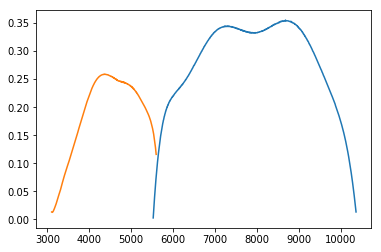

In [21]:
plot(*redqe)
plot(*blueqe)

In [22]:
redqe[0]

array([ 5526.4196,  5530.9667,  5535.5157,  5540.0653,  5544.6163,
        5549.1648,  5554.8548,  5559.4077,  5563.9612,  5568.5156,
        5573.0715,  5577.6264,  5582.1813,  5586.7381,  5591.2959,
        5595.8543,  5600.4136,  5606.1128,  5610.6731,  5615.2348,
        5619.7966,  5624.3598,  5628.9235,  5633.4872,  5638.0533,
        5642.6175,  5647.1836,  5652.8951,  5657.4641,  5662.0327,
        5666.6013,  5671.1709,  5675.7424,  5680.3129,  5684.8844,
        5689.4579,  5694.0338,  5698.6077,  5704.325 ,  5708.9019,
        5713.4798,  5718.0567,  5722.635 ,  5727.2124,  5731.7942,
        5736.374 ,  5740.9538,  5745.5351,  5750.1193,  5755.8459,
        5760.432 ,  5765.0167,  5769.5995,  5774.189 ,  5778.7737,
        5783.3614,  5787.9505,  5792.5376,  5797.1301,  5801.7182,
        5807.4575,  5812.0476,  5816.6421,  5821.2326,  5825.8286,
        5830.4206,  5835.018 ,  5839.6124,  5844.2108,  5848.8058,
        5854.5529,  5859.1552,  5863.7526,  5868.3534,  5872.9

In [23]:
RQE = II.interp1d(*redqe, bounds_error=False, fill_value=0)
BQE = II.interp1d(*blueqe, bounds_error=False, fill_value=0)

In [24]:
RQE(5000)

array(0.)